<a href="https://colab.research.google.com/github/yatowoo/Priconne/blob/main/pcr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Global data

In [1]:
from math import *
from random import uniform as rng
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as cp_dict

In [2]:
LV_MAX = 199
HIT_DAMAGE_LIMIT = 999999

### Character properties

In [3]:
# Properties of Luna

LUNA = {
    'attack': 15666 + (240 + 15 * LV_MAX),
    'critical': 1332,
    'defence_phys': 222,
    'defence_magic': 326,
    'hp': 24090,
    'tp_boost': 13,
    'tp_retain': 28
}

LUNA_4 = {
    'attack': 15093 + (15 + 15 * LV_MAX),
    'critical': 1332,
    'defence_phys': 198,
    'defence_magic': 302,
    'hp': 20535,
    'tp_boost': 13,
    'tp_retain': 28
}

LUNA_3 = {
    'attack': 14519 + (15 + 15 * LV_MAX),
    'critical': 1332,
    'defence_phys': 171,
    'defence_magic': 275,
    'hp': 16977,
    'tp_boost': 13,
    'tp_retain': 28
}


# Properties of Nyaru

NYARU = {
    'attack': 16235 + (240 + 15 * LV_MAX),
    'critical': 1537,
    'defence_phys': 236,
    'defence_magic': 298,
    'hp': 23855,
    'tp_boost': 13,
    'tp_retain': 17
}

NYARU_4 = {
    'attack': 15649 + (15 + 15 * LV_MAX),
    'critical': 1537,
    'defence_phys': 209,
    'defence_magic': 278,
    'hp': 20354,
    'tp_boost': 13,
    'tp_retain': 17
}

NYARU_3 = {
    'attack': 15064 + (15 + 15 * LV_MAX),
    'critical': 1537,
    'defence_phys': 180,
    'defence_magic': 256,
    'hp': 16850,
    'tp_boost': 13,
    'tp_retain': 17
}

# Nuneka
# Rank 12, TP equip ONLY, 12-1/3 + 12-3/5
NUNEKA_ATTACK = 7219 + (240 + 15 * LV_MAX)

### Skills and battle fomules

In [4]:
def buff(buffCoef, lv = LV_MAX):
  return buffCoef * (lv + 1)

def tp_integer(tp_orignal, tp_boost):
  return round(tp_orignal * (1 + tp_boost/100.))

def yukari_tp(tp_boost, lv = LV_MAX):
  return tp_integer(75 + 2.5 *lv, tp_boost)

def miren_tp(tp_boost, lv = LV_MAX):
  return tp_integer(250 + 1.35 * lv, tp_boost)

def uzuki_tp(tp_boost, lv = LV_MAX):
  return tp_integer(50 + 0.3 * lv, tp_boost)

def nuneka_tp(tp_boost, lv = LV_MAX):
  return tp_integer(18 + 0.6 * lv, tp_boost)

def action_tp(tp_boost):
  return tp_integer(90, tp_boost)

def kill_tp(tp_boost):
  return tp_integer(200, tp_boost)

def hurt_tp_magic(damage, role):
  return hurt_tp(damage, role['hp'], role['defence_magic'],role['tp_boost'])

def hurt_tp(damage, hp, defence, tp_boost):
  return tp_integer(damage/(1+defence/100.) / hp * 500, tp_boost)

def hurt_for_UB(nActions, tpBoost, tpRetain, hpMAX, defence, otherTP = 0):
  tpAction = nActions * action_tp(tpBoost)
  dTP = 1000 - 1000 * tpRetain / 100 - tpAction - otherTP
  return dTP / 500 * hpMAX / (1+tpBoost/100.) * (1+ defence/100.)

# Damage for UB shifts
def boss_early_ub(tpBoost, bossHP, nMaxBefore = 5):
  N_MAX = floor(1000 / action_tp(bossInit['tp_boost'])) + 1
  print(N_MAX, ' actions for UB without damage')
  for nAction in range(N_MAX-nMaxBefore, N_MAX):
    damage = round(hurt_for_UB(nAction, tpBoost, 0, bossHP, 0, 0))
    print('Early UB from %d actions, if damage more than : %d' % (N_MAX - nAction, damage))

def LogBarrier(damage, threshold=850000, factor=100000):
    if(damage < threshold):
        return damage
    else:
        return (factor * log((damage-threshold)/factor + 1) + threshold)
  
def critical_rate(criVal, enemyLv, lv = LV_MAX):
    return (0.05 * criVal / 100 * lv / enemyLv)

def critical_damage(orignalDamage, rate, criticalDamageBuff = 0., criticalCoeff = 2.0, defense = 0, logBarrier=False):
    hit = 0
    if(rng(0,1) < rate ):
        hit = round(orignalDamage * criticalCoeff * (1 + criticalDamageBuff))
    else:
        hit = round(orignalDamage)
    if(logBarrier):
      hit = LogBarrier(hit)
    return min(HIT_DAMAGE_LIMIT, round(hit / (1+defense/100.)))

NYARU_UB_BUFF_COEFF = 0.1125
def nyaruUB(attackWithBuff, criticalWithBuff, criticalDamageBuff = 0.,
            enemyLv = LV_MAX, lv = LV_MAX,
            detail=False, magic_defense = 0, logBarrier=False):
    # split in 10 parts = 1/13 * 9 + 4/13
    orignalDamage = 60 * (LV_MAX + 1 ) + 4.8 * attackWithBuff
    hits = []
    for i in ([1] * 9 + [4]):
      hit = critical_damage(orignalDamage*i/13, critical_rate(criticalWithBuff, enemyLv, lv), criticalDamageBuff, defense=magic_defense)
      hits.append(hit)
    totalDamage = sum(hits)
    if(logBarrier):
      effectDamage = LogBarrier(totalDamage)
      ratio = effectDamage / totalDamage
      effectDamage = sum([round(hit * ratio) for hit in hits])
    else:
      effectDamage = round(totalDamage)
    if detail:
        return [round(orignalDamage * 1/13), round(orignalDamage * 4/13), effectDamage]
    else:
        return effectDamage

def NyaruS1(attackWithBuff, enemyDefense, criticalWithBuff, criticalDamageBuff =0., enemyLv = LV_MAX, lv = LV_MAX, logBarrier=False):
   original = 27 * (LV_MAX + 1) + 2.1 * attackWithBuff
   damage = critical_damage(original, critical_rate(criticalWithBuff, enemyLv, lv), criticalDamageBuff, defense = enemyDefense, logBarrier=logBarrier)
   return damage

def NyaruS2_Shield(attackWithBuff):
  return round(buff(3) + 0.08 * attackWithBuff)

def LunaS1(attackWithBuff, enemyDefense, criticalWithBuff, criticalDamageBuff = 0., enemyLv = LV_MAX, lv = LV_MAX):
    return round(critical_damage(attackWithBuff, critical_rate(criticalWithBuff, enemyLv, lv), criticalDamageBuff, defense=enemyDefense))

def LunaS2(attackWithBuff, enemyDefense, criticalWithBuff, friendFlag=0, criticalDamageBuff =0., enemyLv = LV_MAX, lv = LV_MAX, logBarrier=False):
  if(friendFlag <2):
    original = 20 * (LV_MAX + 1) + 1.6 * attackWithBuff
  else:
    original = 40 * (LV_MAX + 1) + 3.2 * attackWithBuff
  damage = critical_damage(original, critical_rate(criticalWithBuff, enemyLv, lv), criticalDamageBuff, defense = enemyDefense, logBarrier=logBarrier)
  return damage

def LunaUB(attackWithBuff, enemyDefense, criticalWithBuff, friendFlag=5, criticalDamageBuff =0., enemyLv = LV_MAX, lv = LV_MAX):
  original = 12.5 * (LV_MAX +1) + (1.0 + min(5, friendFlag) * 1.2)
  # divide into 5 hits, each took 1/5 damage
  hits = []
  for i in ([1] * 5):
    hit = critical_damage(original*i/5, critical_rate(criticalWithBuff, enemyLv, lv), criticalDamageBuff, defense=enemyDefense)
    hits.append(round(hit))
  return sum(hits)

#### Test : Nyaru UB damage distribution
Nyaru's UB is splitted into 10 hits, including the first 9 hits took 1/13 damage and the last hit took 4/13. For simplicity, I suppose the critical for each hit is calculated independently. 

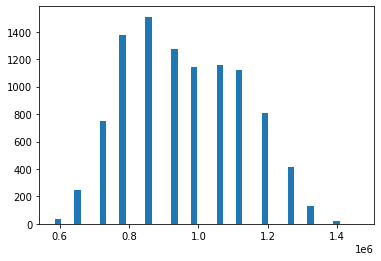

In [5]:
nyaruTest = lambda x : nyaruUB(NYARU['attack'] + x, NYARU['critical']+180,0.25,400)
a = [nyaruTest(100000) for i in range(0,10000)]
_ = plt.hist(a, bins='auto')

Nyaru UB to reach digit barrier without log barrier. Require around **24M** damage by UB in last 18 seconds.

In [6]:
totalDamageIn18s = (999999*13/4.8-NYARU['attack'])/NYARU_UB_BUFF_COEFF
d = nyaruUB(NYARU['attack'] + totalDamageIn18s*NYARU_UB_BUFF_COEFF, NYARU['critical'],0.15,400, LV_MAX, True)
print(d)
print(d[0]*9 + 999999)
print(totalDamageIn18s)

[1000922, 4003688, 9999990]
10008297
23901072.22222222


#### Test: Damage needed for UB 

In [7]:
# Nyaru with Yukari and Luna at 1:18
print('Hit4UB, LunaATK, BuffCoef')
for chara in [NYARU, NYARU_4, NYARU_3]:
  hurtNyaru = round( hurt_for_UB(2, chara['tp_boost'], 0, chara['hp'], chara['defence_magic'], yukari_tp(chara['tp_boost'])))
  buffNeeded = round( (hurtNyaru-LUNA['attack'])/(LV_MAX+1) )
  print(hurtNyaru, LUNA['attack'], buffNeeded, sep=' , ')

print(yukari_tp(NYARU['tp_boost']))

Hit4UB, LunaATK, BuffCoef
25038 , 18891 , 31
20290 , 18891 , 7
15819 , 18891 , -15
647


In [8]:
LogBarrier(1500000) + 1500000/3.
critBuff = 0.16 * 5 + 0.1 * 6 + 0.05
atkBuff = buff(10.5 * 6 + 15 *6 + 28 *6 + 22.5 * 5 + 20 + 12.5)
(150/(2 * (1+critBuff))/2.4-2.1)*1e4 - atkBuff
atkBuff

93200.0

### TP interger check

In [9]:
# Miren, Uzuki TP charge
print("TP Boost\tAction\tMiren\tUzuki\tYukari")
for tp_boost in [6, 8, 11, 13, 16, 21, 26, 28, 31, 33, 34, 35, 36, 39, 40, 43, 46, 50, 54, 56, 66]:
    print("%d\t\t%d\t\t%d\t\t%d\t\t%d" % (tp_boost, action_tp(tp_boost), miren_tp(tp_boost), uzuki_tp(tp_boost+8), yukari_tp(tp_boost)))

TP Boost	Action	Miren	Uzuki	Yukari
6		95		550		125		607
8		97		560		127		618
11		100		576		131		635
13		102		586		133		647
16		104		602		136		664
21		109		628		142		693
26		113		653		147		721
28		115		664		149		733
31		118		679		152		750
33		120		690		155		761
34		121		695		156		767
35		122		700		157		773
36		122		705		158		779
39		125		721		161		796
40		126		726		162		802
43		129		742		166		819
46		131		757		169		836
50		135		778		173		859
54		139		799		178		882
56		140		809		180		893
66		149		861		191		950


## Timeline simulation

Timeline:
* Objects: Characters, Boss(es), Summon(s)
* Properties: Initial stats, Skill/Actions (formula, animation and loop)
* Status: + HP/TP, (Position) for each object
* Status recorder: to record status change, store array of delta value of properties with target object and timestamp of start and end

In [10]:
# Class: Status recorder
# Data: LIST for delta information (DICT)
# Methods: input object, TIMESTAMP and properties, return accumulated buff/debuff and current status
# Status change (buff/debuff): 
#   physic_attack, magic_attack
#   physic_defence, magic_defence
#   physic_critical, magic_critical, physical_critical_damage, magic_critical_damage
#   TP boost
#   speed (final value, not delta)
#   field (overlap?)
#   Other: HP drain rate, HOT/DOT
#   Info: caster, target (name/ID), timestamp (start/end) [seconds or frame?]

class StatusRecorder:
  STATS_NAME = ['atk_phy', 'atk_mag', 'def_phy', 'def_mag', 'crit_phy', 'crit_mag', 'crit_damage_phy', 'crit_damage_mag','tp_boost','speed']
  INFO_NAME = ['caster', 'target', 'start', 'stop', 'duration']
  party = []
  objects = []
  status_delta = []
  status_delta_template = {}
  def __init__(self, party):
    self.status_delta = []
    self.party = party
    self.objects = party + ['boss']
  # Input check and change function object abbr to list
  def append(self, newStatusChange):
    # Argument type check
    if(type(newStatusChange) is not dict or not bool(newStatusChange)):
      print('[X] Argument error - require dict with stats name and value - from StatusRecorder.append')
      return False
    delta =cp_dict(newStatusChange)
    # Name check
    for k in delta.keys():
      if(k not in self.STATS_NAME + self.INFO_NAME):
        print('[X] Argument error - can not find key ' + repr(k) + ' - from StatusRecorder.append')
        return False
    # Target check
    tgt = delta['target']
    if(type(tgt) is not list):
      if(tgt is 'all'):
        delta['target'] = self.party
      elif(tgt in self.objects):
          delta['target'] = [tgt]
      else:
        print('[X] Argument error - can not find target ' +repr(tgt) + ' in current party ' + repr(self.party) + '- from StatusRecorder.append')
    else:
      for name in tgt:
        if(name not in self.objects):
          print('[X] Argument error - can not find target ' +repr(name) + ' in current battle ' + repr(self.objects) + '- from StatusRecorder.append')
    # End time
    delta['stop'] = delta['start'] - delta['duration']
    self.status_delta.append(delta)
    return True
  def addAtkBuff(self, buffValue, timestamp, duration=12, buffCritical = 0, buffCritDamage=0, buffType='phy', target='all', caster=None):
    delta = {'start': timestamp, 'stop': timestamp - duration, 'duration': duration, 'target': target, 'caster': caster}
    if(buffType is 'phy'):
      delta['atk_phy'] = buffValue
      delta['crit_phy'] = buffCritical
      delta['crit_damage_phy'] = buffCritDamage
    elif(buffType is 'mag'):
      delta['atk_mag'] = buffValue
      delta['crit_mag'] = buffCritical
      delta['crit_damage_mag'] = buffCritDamage
    else:
      print('[X] Input buff type error - ', buffType, ' not defined - from StatusRecorder.addAtkBuff')
      return
    return self.append(delta)
  def update(self, deltaVal, timestamp, duration = 12, statsType='atk_phy', target='all', caster=None):
    delta = {'start': timestamp, 'stop': timestamp - duration, 'duration': duration, 'target': target, 'caster': caster}
    delta[statsType] = deltaVal
    return self.append(delta)
  def getStatus(self, initStats, target, timestamp=90, statsKey='all'):
    nowStats = cp_dict(initStats)
    for delta in self.status_delta:
      if(delta['stop'] > timestamp or  delta['start'] < timestamp or target not in delta['target']):
        continue
      for k in [name for name in delta.keys() if name not in self.INFO_NAME]:
        nowStats[k] += delta[k]
    # Value check - non-zero stats
    for k in [name for name in nowStats.keys() if name in self.STATS_NAME and name not in self.INFO_NAME]:
      nowStats[k] = max(0, nowStats[k])
    if(statsKey is 'all'):
      return nowStats
    else:
      return nowStats[statsKey]
# END - Class definition

### Decorator for Chara Skills

In [18]:
statsRec = StatusRecorder(['yukari', 'anna', 'akari', 'nyaru', 'luna'])

initStats = {}
initStats['nyaru'] = {'atk_mag':NYARU['attack'], 'crit_mag':NYARU['critical']}
initStats['boss'] = {'name': '2021/05 C4', 'lv': 115, 'HP': 18000000, 'def_phy': 300, 'def_mag': 290, 'tp_boost':40}
for k in [x for x in statsRec.STATS_NAME if x not in initStats['nyaru'].keys()]:
  initStats['nyaru'][k] = 0.
damageRec = {}
for name in statsRec.party:
  damageRec[name] = []

FLAG_DEBUG = False
FLAG_LOGBARRIER = True
# Attack
def action_attack(timestamp, name):
  charaNow = statsRec.getStatus(initStats[name], name, timestamp)
  bossNow = statsRec.getStatus(initStats['boss'], 'boss', timestamp)
  # Attack type
  if(charaNow['atk_phy'] < charaNow['atk_mag']):
    hits = critical_damage(charaNow['atk_mag'],
                         critical_rate(charaNow['crit_mag'], bossNow['lv']), charaNow['crit_damage_mag'], 
                         defense = bossNow['def_mag'], logBarrier=FLAG_LOGBARRIER)
  else:
    hits = critical_damage(charaNow['atk_phy'],
                         critical_rate(charaNow['crit_phy'], bossNow['lv']), charaNow['crit_damage_phy'], 
                         defense = bossNow['def_phy'], logBarrier=FLAG_LOGBARRIER)
  if(FLAG_DEBUG):
    print('Time ' + repr(timestamp) + 's : ' + name + ' attack - ' +repr(hits))
  damageRec[name].append(hits)
  return hits

# Nyaru - Kyaru (New Year)
def action_nyaru_ub(timestamp):
  charaNow = statsRec.getStatus(initStats['nyaru'], 'nyaru', timestamp)
  bossNow = statsRec.getStatus(initStats['boss'], 'boss', timestamp)
  hits = nyaruUB(charaNow['atk_mag'], charaNow['crit_mag'], charaNow['crit_damage_mag'], 
                 enemyLv=bossNow['lv'], magic_defense = bossNow['def_mag'],
                 detail=True, logBarrier=FLAG_LOGBARRIER)
  if(FLAG_DEBUG):
    print('Time ' + repr(timestamp) + 's : Nyaru UB - ' +repr(hits))
  damage = hits[2]
  statsRec.addAtkBuff(buff(10) + round(damage * NYARU_UB_BUFF_COEFF), 
                      timestamp, duration=18, buffType='mag', target='nyaru')
  damageRec['nyaru'].append(damage)
  return round(damage)

def action_nyaru_s1(timestamp):
  charaNow = statsRec.getStatus(initStats['nyaru'], 'nyaru', timestamp)
  bossNow = statsRec.getStatus(initStats['boss'], 'boss', timestamp)
  hits = NyaruS1(charaNow['atk_mag'], bossNow['def_mag'], charaNow['crit_mag'],  charaNow['crit_damage_mag'], 
                 enemyLv=bossNow['lv'], logBarrier=FLAG_LOGBARRIER)
  if(FLAG_DEBUG):
    print('Time ' + repr(timestamp) + 's : Nyaru S1 - ' +repr(hits))
  damageRec['nyaru'].append(hits)
  return hits

# Luna
COUNTER_LunaFriends = 5
def action_luna_ub(timestamp):
  charaNow = statsRec.getStatus(initStats['luna'], 'luna', timestamp)
  bossNow = statsRec.getStatus(initStats['boss'], 'boss', timestamp)
  hits = LunaUB(charaNow['atk_mag'], bossNow['def_mag'], charaNow['crit_mag'], COUNTER_LunaFriends, 
                charaNow['crit_damage_mag'], enemyLv=bossNow['lv'])
  if(FLAG_DEBUG):
    print('Time ' + repr(timestamp) + 's : Luna attack - ' +repr(hits))
  damageRec['luna'].append(hits)
  return hits

def action_luna_s2(timestamp):
  charaNow = statsRec.getStatus(initStats['luna'], 'luna', timestamp)
  bossNow = statsRec.getStatus(initStats['boss'], 'boss', timestamp)
  hits = LunaS2(charaNow['atk_mag'], bossNow['def_mag'], charaNow['crit_mag'], COUNTER_LunaFriends, 
                charaNow['crit_damage_mag'], enemyLv=bossNow['lv'])
  if(FLAG_DEBUG):
    print('Time ' + repr(timestamp) + 's : Luna S2 - ' +repr(hits))
  damageRec['luna'].append(hits)
  return hits

# TODO: accept target from string
action_luna_s1 = lambda x : statsRec.addAtkBuff(buff(7.5), timestamp=x, buffCritical=100, buffType='mag', target='nyaru')

# Buff/Debuff - Simple skills
  # TODO: speed to 1.25
action_ouka_s1 = lambda x : statsRec.addAtkBuff(buff(16), timestamp=x, duration=12, buffCritical=75, 
                                                buffType='mag', target='all')
action_ouka_s2 = lambda x: statsRec.update(-buff(0.6), x, 12, 'def_mag', 'boss')
action_nyaru_s2 = lambda x: statsRec.addAtkBuff(buff(6), timestamp=x, buffType='mag', target='all')
def action_akari_ub(timestamp):
  statsRec.addAtkBuff(buff(24), timestamp, 18, buffCritical=100, buffType='mag', target='all')
  statsRec.update(-buff(0.66), timestamp, 18, 'def_mag', 'boss')
def action_miren_ub(timestamp):
  #TODO: speed to 1.5
  statsRec.addAtkBuff(buff(10.5), timestamp, 12, buffType='mag', target='all')
  statsRec.addAtkBuff(buff(10.5), timestamp, 12, buffType='phy', target='all')
def action_miren_s1(timestamp):
  # TODO: TP charge
  statsRec.addAtkBuff(buff(18), timestamp, 20, buffType='mag', target='all')
  statsRec.addAtkBuff(buff(18), timestamp, 20, buffType='phy', target='all')
def action_miren_s2(timestamp):
  statsRec.addAtkBuff(buff(2.5), timestamp, 12, buffCritical=20, buffType='mag', target='all')
  statsRec.addAtkBuff(buff(2.5), timestamp, 12, buffCritical=20, buffType='phy', target='all')

### Test: Run action and timeline

In [19]:
FLAG_DEBUG = True

statsRec.status_delta = []
statsRec.update(-300, 90, 90, statsType='def_mag', target='boss')
tl_tmp = [(84, 'miren_s1'), (82, 'ouka_s2'), (78, 'ouka_s1'), (76, 'nyaru_attack')]

def RunTimeline(timeline):
  # Run timeline
  for timestamp, action in timeline:
    # Run Action
    if(callable(action)):
      action(timestamp)
    else:
      name = action.split('_')[0]
      skill = action.split('_')[1]
      if(skill == 'a' or skill == 'attack'):
        globals()['action_attack'](timestamp, name)
      else:
        globals()['action_' + action](timestamp)

RunTimeline(tl_tmp)

Time 76s : nyaru attack - 52520


### Test : class StatusRecorder

Case: 2020/05, C4 [video from Hanmario](https://youtu.be/n0Ht7fAF744)

Party: Yukari, Anna, Akari, Nyaru, Luna

**ISSUE**: Damage difference with Nyaru UB at 0:30, (video) 1194154 vs 1188894 (simulation)
```
TL
118　にゃる
116　アカリ
115　にゃる　通常後
110　にゃる　フィールドキャンセル
104　にゃる　バレット後
102　ルナ
053　ユカリ
048　アカリ
047　にゃる
　　　にゃる
031　にゃる　ムンラ
　　　ユカリ
　　　にゃる　ソルコン
　　　ルナ
025　にゃるバレット討伐？足りないならアンナUB
```

In [15]:
statsRec = StatusRecorder(['yukari', 'anna', 'akari', 'nyaru', 'luna'])
luna = LUNA
nyaru = NYARU_3
nyaruInit = {'atk_mag':nyaru['attack'], 'crit_mag':nyaru['critical'], 'crit_damage_mag': 0}
bossInit = {'name': '2021/05 C4', 'lv': 115, 'HP': 18000000, 'def_phy': 300, 'def_mag': 290, 'tp_boost':40}
damageRec = {}
for name in statsRec.party:
  damageRec[name] = []

DEBUG_FLAG = True
def HitNyaruUB(timestamp, debug=False):
  nyaruNow = statsRec.getStatus(nyaruInit, 'nyaru', timestamp)
  bossNow = statsRec.getStatus(bossInit, 'boss', timestamp)
  hits = nyaruUB(nyaruNow['atk_mag'], nyaruNow['crit_mag'], nyaruNow['crit_damage_mag'], 
                 enemyLv=bossInit['lv'], magic_defense = bossNow['def_mag'],
                 detail=True, logBarrier=True)
  if(debug or DEBUG_FLAG):
    print('Time ' + repr(timestamp) + 's : Nyaru UB - ' +repr(hits))
  damage = hits[2]
  statsRec.addAtkBuff(buff(10) + round(damage * NYARU_UB_BUFF_COEFF), timestamp, duration=18, buffType='mag', target='nyaru')
  damageRec['nyaru'].append(damage)
  return round(damage)
def HitNyaruAttack(timestamp, debug=False):
  nyaruNow = statsRec.getStatus(nyaruInit, 'nyaru', timestamp)
  bossNow = statsRec.getStatus(bossInit, 'boss', timestamp)
  hits = critical_damage(nyaruNow['atk_mag'],
                         critical_rate(nyaruNow['crit_mag'], bossNow['lv']), nyaruNow['crit_damage_mag'], defense = bossNow['def_mag'], logBarrier=True)
  if(debug or DEBUG_FLAG):
    print('Time ' + repr(timestamp) + 's : Nyaru attack - ' +repr(hits))
  damageRec['nyaru'].append(hits)
  return hits
def HitNyaruS1(timestamp, debug=False):
  nyaruNow = statsRec.getStatus(nyaruInit, 'nyaru', timestamp)
  bossNow = statsRec.getStatus(bossInit, 'boss', timestamp)
  hits = NyaruS1(nyaruNow['atk_mag'], bossNow['def_mag'], nyaruNow['crit_mag'],  nyaruNow['crit_damage_mag'], enemyLv=bossNow['lv'], logBarrier=True)
  if(debug or DEBUG_FLAG):
    print('Time ' + repr(timestamp) + 's : Nyaru S1 - ' +repr(hits))
  damageRec['nyaru'].append(hits)
  return hits

# Timeline
HitLunaS1 = lambda x, y : statsRec.addAtkBuff(buff(7.5), timestamp=x, buffCritical=100, buffType='mag', target=y)
# DEBUG: set boss defence to 0 from start (most of time)
statsRec.update(-buff(1.6), 90, 90, 'def_mag', 'boss')
#1:23 Nyaru S2
statsRec.addAtkBuff(buff(6), 83, buffType='mag')
#1:18 Luna S1
HitNyaruUB(78)
HitLunaS1(78, 'nyaru')
#1:16 Akari UB
statsRec.addAtkBuff(buff(24), 76, 18, 100, buffType='mag')
HitNyaruAttack(75)
HitNyaruUB(75)
HitNyaruS1(72)
#1:11 Luna S1
HitLunaS1(71, 'nyaru')
HitNyaruUB(70)
HitNyaruAttack(67)
HitNyaruS1(64) # 917311
#1:04 Luna S1
HitLunaS1(64, 'nyaru')
HitNyaruUB(64)
HitNyaruAttack(60) # 700164
HitNyaruAttack(57) # 636552
#DEBUG
statsRec.update(buff(0.8), 53, 1, 'def_mag', 'boss')
HitNyaruS1(53) # 476597, boss debuff=0.8, rest defence=290-200*0.8=130
#0:51 Nyaru S2
statsRec.addAtkBuff(buff(6), 51, buffType='mag')
#0:48 Akari UB
statsRec.addAtkBuff(buff(24), 48, 18, 100, buffType='mag')
HitNyaruUB(47)
HitLunaS1(47,'nyaru')
HitNyaruUB(47)
HitNyaruS1(44) # 993747
HitNyaruAttack(41) # 552476
HitNyaruAttack(36) # 550076
HitNyaruS1(33) # 991016
HitNyaruUB(31)
HitLunaS1(30,'nyaru')
HitNyaruUB(30)
HitNyaruAttack(28) # 573310
HitNyaruS1(25) # 999999
# Results
STATS_NYARU_VIDEO = 15757521
simDamageNyaru = sum(damageRec['nyaru'])
errorTotal = (simDamageNyaru - STATS_NYARU_VIDEO) / float(STATS_NYARU_VIDEO)
print('Simulation result (Nyaru total damage) : %d vs %d, error=%.2f%%' % (simDamageNyaru, STATS_NYARU_VIDEO, errorTotal*100))

Time 78s : Nyaru UB - [8036, 32144, 208936]
Time 75s : Nyaru attack - 102138
Time 75s : Nyaru UB - [19779, 79117, 514266]
Time 72s : Nyaru S1 - 476681
Time 70s : Nyaru UB - [41990, 167962, 972893]
Time 67s : Nyaru attack - 445348
Time 64s : Nyaru S1 - 914044
Time 64s : Nyaru UB - [83141, 332565, 1114737]
Time 60s : Nyaru attack - 700164
Time 57s : Nyaru attack - 636554
Time 53s : Nyaru S1 - 423555
Time 47s : Nyaru UB - [56851, 227405, 1048530]
Time 47s : Nyaru UB - [101698, 406792, 1144132]
Time 44s : Nyaru S1 - 993747
Time 41s : Nyaru attack - 552478
Time 36s : Nyaru attack - 550078
Time 33s : Nyaru S1 - 991017
Time 31s : Nyaru UB - [101922, 407688, 1144442]
Time 30s : Nyaru UB - [150753, 603011, 1188894]
Time 28s : Nyaru attack - 572130
Time 25s : Nyaru S1 - 999999
Simulation result (Nyaru total damage) : 15694763 vs 15757521, error=-0.40%


## Clan Battle
Timeline simulation & Utility computing tools

### 2021/05 E3
Boss: オークチーフ

Skill:
* UB: 前方３キャラに物理大ダメージを与え、さらにスタンさせる
* S1: 前方２キャラの物理防御力を大ダウンし、さらにＴＰを中ダウン
* Loop: AA-S1 (AAAA-S1)

Patterns
* Rima Ouka, [video](https://youtu.be/lK1vzGOJv6M)
* Ouka Miren, [video](https://youtu.be/gjxhD7-Lxjw)

Text(0.5, 0, 'Total damage / 1e4')

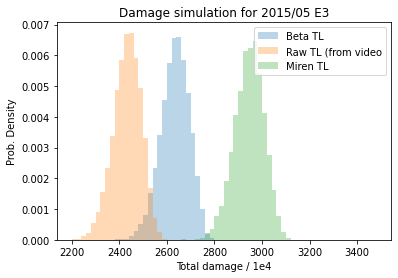

In [32]:
#Ref. 2021/05 E3 
statsRec = StatusRecorder(['yukari', 'ouka', 'lima', 'nyaru', 'luna'])
luna = LUNA
nyaru = NYARU
nyaruInit = {'atk_mag':nyaru['attack'], 'crit_mag':nyaru['critical'], 'crit_damage_mag': 0}
lunaInit =  {'atk_mag':luna['attack'], 'crit_mag':luna['critical'], 'crit_damage_mag': 0}
damageRec = {}
for name in statsRec.party:
  damageRec[name] = []

# Boss
bossInit = {
    'name': '2021/05 E3',
    'lv': 210,
    'hp': 22000000,
    'def_phy': 100,
    'def_mag': 100,
    'UB_damage': 13.5 * (200 +1) + 4.0 * 45000,
    'Attack_damage': 13.5 * (200 +1) + (2.0 + 0.02 * 200) * 45000}

DEBUG_FLAG = True
# Skills
BuffOukaS1 = lambda x : statsRec.addAtkBuff(buff(16), timestamp=x, duration=12, buffCritical=75, buffType='mag', target='all')
BuffNyaruS2 = lambda x: statsRec.addAtkBuff(buff(6), timestamp=x, buffType='mag', target='all')
DebuffOukaS2 = lambda x: statsRec.update(-buff(0.6), x, 12, 'def_mag', 'boss')
# Luna
BuffLunaS1 = lambda x : statsRec.addAtkBuff(buff(7.5), timestamp=x, buffCritical=100, buffType='mag', target='nyaru')
COUNTER_LunaFriends = 5
def HitLunaUB(timestamp, debug=False):
  charaNow = statsRec.getStatus(lunaInit, 'luna', timestamp)
  bossNow = statsRec.getStatus(bossInit, 'boss', timestamp)
  hits = LunaUB(charaNow['atk_mag'], bossNow['def_mag'], charaNow['crit_mag'], COUNTER_LunaFriends, charaNow['crit_damage_mag'], enemyLv=bossNow['lv'])
  if(debug or DEBUG_FLAG):
    print('Time ' + repr(timestamp) + 's : Luna attack - ' +repr(hits))
  damageRec['luna'].append(hits)
  return hits
def HitLunaAttack(timestamp, debug=False):
  charaNow = statsRec.getStatus(lunaInit, 'luna', timestamp)
  bossNow = statsRec.getStatus(bossInit, 'boss', timestamp)
  hits = critical_damage(charaNow['atk_mag'],
                         critical_rate(charaNow['crit_mag'], bossNow['lv']), charaNow['crit_damage_mag'], defense = bossNow['def_mag'])
  if(debug or DEBUG_FLAG):
    print('Time ' + repr(timestamp) + 's : Luna attack - ' +repr(hits))
  damageRec['luna'].append(hits)
  return hits
def HitLunaS2(timestamp, debug=False):
  charaNow = statsRec.getStatus(lunaInit, 'luna', timestamp)
  bossNow = statsRec.getStatus(bossInit, 'boss', timestamp)
  hits = LunaS2(charaNow['atk_mag'], bossNow['def_mag'], charaNow['crit_mag'], COUNTER_LunaFriends, charaNow['crit_damage_mag'], enemyLv=bossNow['lv'])
  if(debug or DEBUG_FLAG):
    print('Time ' + repr(timestamp) + 's : Luna S2 - ' +repr(hits))
  damageRec['luna'].append(hits)
  return hits

# Timeline
timelineBeta = [
            (83, BuffNyaruS2), (81.5, DebuffOukaS2), (78, HitNyaruS1), (78, BuffLunaS1), (78, BuffOukaS1),
            (78, HitNyaruUB), (74, HitNyaruAttack), (74, HitLunaAttack),
            (74, HitNyaruUB), (72, HitNyaruS1), (71, BuffLunaS1),
            (71, HitNyaruUB), (68.5, DebuffOukaS2), (68, HitNyaruAttack), (67, HitLunaS2), (66, HitNyaruS1), (65, BuffLunaS1),
            (65, HitNyaruUB), (62, BuffOukaS1), (62, HitLunaUB), (62, HitNyaruAttack), (59, HitLunaAttack), (59, HitNyaruAttack),
            (59, HitNyaruUB), (56, HitLunaS2), (56, HitNyaruS1), (54, BuffNyaruS2), (53, HitLunaAttack), (51, BuffLunaS1),
            (50, DebuffOukaS2), (49, HitNyaruAttack), (49, HitNyaruUB), (47, HitLunaAttack), (46, HitNyaruS1),
              (43.5, HitLunaAttack), (43, BuffOukaS1), (42, HitNyaruAttack),
            (40, HitNyaruUB), (40, HitLunaS2), (40, HitLunaUB), (39, HitNyaruAttack), (37, HitLunaAttack), (36, HitNyaruS1),
            (34, DebuffOukaS2), (35, BuffLunaS1), (34, BuffNyaruS2), (34, HitNyaruUB), (31, HitLunaAttack), (31, HitNyaruAttack),
              (28, BuffOukaS1), (28, HitLunaAttack), (28, HitNyaruS1),
            (26, HitNyaruUB), (24, HitLunaS2), (24, HitNyaruAttack), (23, HitLunaUB), (21, HitNyaruAttack), (20, BuffLunaS1), 
              (20, DebuffOukaS2), (17, HitNyaruS1), (17, HitLunaAttack),
            (17, HitNyaruUB), (14, HitLunaAttack), (14, HitNyaruAttack), (13, BuffOukaS1), (11, HitNyaruS1),
            (10, HitNyaruUB), (10, HitLunaS2), (7, HitNyaruAttack), (7, HitLunaAttack), (5, DebuffOukaS2),  (4, BuffLunaS1), (4, HitNyaruAttack),
            (4, HitNyaruUB), (4, HitLunaUB), (1, HitNyaruS1), (1, HitLunaAttack)
]

timelineVideo = [
            (83, BuffNyaruS2), (81.5, DebuffOukaS2), (78, HitNyaruS1), (78, BuffLunaS1), (78, BuffOukaS1),
            (78, HitNyaruUB), (74, HitNyaruAttack), (74, HitLunaAttack),
            (74, HitNyaruUB), (72, HitNyaruS1), (71, BuffLunaS1),
            (71, HitNyaruUB), (68.5, DebuffOukaS2), (68, HitNyaruAttack), (67, HitLunaS2), (66, HitNyaruS1), (65, BuffLunaS1),
            (65, HitNyaruUB), (62, BuffOukaS1), (62, HitNyaruAttack), (61, HitLunaAttack), (59, HitNyaruAttack),
            (59, HitNyaruUB), (58, HitLunaAttack), (57, HitLunaUB), (56, HitNyaruS1), (54, BuffNyaruS2), (54, HitLunaAttack), (51, BuffLunaS1),
            (51, HitNyaruUB), (50, DebuffOukaS2), (49, HitNyaruAttack), (48, HitLunaAttack), (46, HitNyaruS1),
              (44, HitLunaAttack), (43, BuffOukaS1), (42, HitNyaruAttack), (41, HitLunaS2),
            (40, HitNyaruUB), (39, HitNyaruAttack), (38.5, HitLunaAttack), (36, HitNyaruS1), (35, BuffLunaS1),
            (35, HitNyaruUB), (34, DebuffOukaS2), (34, BuffNyaruS2), (32, HitLunaAttack), (29, HitNyaruAttack),
              (29, HitLunaAttack), (28, BuffOukaS1), (26, HitNyaruS1),
            (26, HitNyaruUB), (26, HitLunaUB), (23, HitNyaruAttack), (23, HitLunaAttack), (20, BuffLunaS1), (20, HitNyaruAttack),
            (20, HitNyaruUB), (20, DebuffOukaS2),  (17, HitNyaruS1), (17, HitLunaAttack), (15, BuffNyaruS2),
              (14, HitLunaAttack), (12, BuffOukaS1), (10, HitLunaS2), (10, HitNyaruAttack),
            (10, HitNyaruUB), (7, HitNyaruS1), (7, HitLunaAttack), (4, BuffLunaS1), (4, DebuffOukaS2), (3, HitNyaruAttack),
            (3, HitNyaruUB), (3, HitLunaUB), (1, HitNyaruAttack), (1, HitLunaAttack)
]

tlMiren = [
           (84, 'miren_s1'), (83, 'nyaru_s2'), (82, 'ouka_s2'), (78, 'ouka_s1'),
           (78, 'nyaru_ub'), (78, 'luna_s1'), (78, 'nyaru_ub'), (75.1, 'nyaru_a'), (75, 'miren_s2'), (74, 'luna_a'), (74, 'nyaru_s1'),
           (72, 'nyaru_ub'), (70, 'nyaru_s2'), (70, 'nyaru_ub'), (70, 'luna_ub'), (69, 'miren_ub'), (69, 'ouka_s2'),
            (67, 'nyaru_a'), (67, 'luna_s1'), (67, 'miren_s2'), (65, 'nyaru_s1'),
           (65, 'nyaru_ub'), (62, 'nyaru_a'), (61, 'luna_a'), (59, 'nyaru_a'), (56, 'nyaru_s1'), (55, 'luna_a'), (54, 'nyaru_s2'),
           (54, 'nyaru_ub'), (53, 'ouka_s2'), (52, 'luna_s1'), (51, 'luna_ub'), (51, 'nyaru_a'),
           (51,'nyaru_ub'), (48, 'nyaru_s1'), (48, 'luna_a'), (46, 'miren_s2'), (46, 'ouka_s1'), (44, 'nyaru_a'), (44, 'miren_ub'),
            (41, 'luna_s2'), (41, 'nyaru_a'),
           (41, 'nyaru_ub'), (39, 'luna_a'), (38.1, 'nyaru_s1'), (38, 'ouka_s2'), (37, 'miren_s2'), (37, 'nyaru_s2'),
           (36, 'nyaru_ub'), (33, 'nyaru_a'), (33, 'luna_a'), (32, 'ouka_s1'), (31, 'nyaru_s1'), (30, 'luna_a'),
           (29, 'nyaru_ub'), (29, 'luna_ub'), (28, 'miren_s2'), (27, 'nyaru_a'), (27, 'luna_s2'), (24, 'nyaru_a'), (23, 'luna_a'),
            (22, 'nyaru_s1'), (20.1, 'ouka_s2'), (20.1, 'nyaru_s2'), (20.1, 'luna_s1'), (20.1, 'miren_s2'),
           (20, 'nyaru_ub'), (17, 'luna_a'), (17, 'nyaru_a'), (14.1, 'ouka_s1'), (14, 'luna_a'), (14, 'nyaru_s1'),
           (14, 'nyaru_ub'), (14, 'luna_ub'), (11, 'nyaru_a'), (11, 'luna_a'), (11, 'miren_s2'), (8.2, 'nyaru_a'), (8, 'luna_s1'),
           (8, 'nyaru_ub'), (7, 'ouka_s2'), (6, 'nyaru_s1'), (5, 'luna_a'), (3, 'nyaru_s2'), (1, 'luna_a'), (1, 'miren_s2'), (1, 'miren_ub'),
           (1, 'nyaru_ub')
]

DEBUG_FLAG = False
FLAG_DEBUG = False
N_EVENT = 10000

histDamage = []
histNyaruFieldAt34 = []
tmpRec = None
for ev in range(0, N_EVENT):
  damageRec = {}
  for name in statsRec.party:
    damageRec[name] = []
  statsRec.status_delta = []
  for action in timelineBeta:
    action[1](action[0])
  nyaruAttack = statsRec.getStatus(nyaruInit, 'nyaru', 34.5, 'atk_mag')
  histNyaruFieldAt34.append( nyaruAttack * 0.08 + buff(3))
  totalDamage = (sum(damageRec['nyaru']) + sum(damageRec['luna'])) / 10000. + 40
  histDamage.append(totalDamage)

histDamageOriginal = []
for ev in range(0, N_EVENT):
  damageRec = {}
  for name in statsRec.party:
    damageRec[name] = []
  statsRec.status_delta = []
  for action in timelineVideo:
    action[1](action[0])
  totalDamage = (sum(damageRec['nyaru']) + sum(damageRec['luna'])) / 10000. + 40
  histDamageOriginal.append(totalDamage)


statsRec = StatusRecorder(['yukari', 'ouka', 'miren', 'nyaru', 'luna'])
initStats = {}
initStats['nyaru'] = {'atk_mag':NYARU['attack'], 'crit_mag':NYARU['critical']}
initStats['luna'] = {'atk_mag':luna['attack'], 'crit_mag':luna['critical']}
initStats['boss'] = {
    'name': '2021/05 E3',
    'lv': 210,
    'hp': 22000000,
    'def_phy': 100,
    'def_mag': 100,
    'UB': 13.5 * (200 +1) + 4.0 * 45000,
    'Attack': 13.5 * (200 +1) + (2.0 + 0.02 * 200) * 45000}
for k in [x for x in statsRec.STATS_NAME if x not in initStats['nyaru'].keys()]:
  initStats['nyaru'][k] = 0.
  initStats['luna'][k] = 0.
damageRec = {}
for name in statsRec.party:
  damageRec[name] = []
histDamageMiren = []
for ev in range(0, N_EVENT):
  damageRec = {}
  for name in statsRec.party:
    damageRec[name] = []
  statsRec.status_delta = []
  RunTimeline(tlMiren)
  totalDamage = (sum(damageRec['nyaru']) + sum(damageRec['luna'])) / 10000. + 40
  histDamageMiren.append(totalDamage)

fig, ax = plt.subplots()
pltKwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=range(2200, 3500, 20))
plotBeta = plt.hist(histDamage, **pltKwargs, label='Beta TL')
plotRaw = plt.hist(histDamageOriginal, **pltKwargs, label='Raw TL (from video')
plotMiren = plt.hist(histDamageMiren, **pltKwargs, label='Miren TL')
leg = ax.legend()
plt.title('Damage simulation for 2015/05 E3')
plt.ylabel('Prob. Density')
plt.xlabel('Total damage / 1e4')

In [31]:
sum(damageRec['nyaru'])

28525729

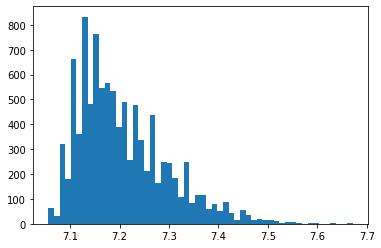

In [ ]:
defRequire = [bossInit['UB_damage'] / x - 1 for x in histNyaruFieldAt34]
_ = plt.hist(defRequire, bins='auto')

In [ ]:
bossInit = {
    'name': '2021/05 E3',
    'lv': 210,
    'hp': 22000000,
    'def_phy': 100,
    'def_mag': 100,
    'tp_boost': 10,
    'UB_damage': 13.5 * (200 +1) + 4.0 * 45000,
    'Attack_damage': 13.5 * (200 +1) + (2.0 + 0.02 * 200) * 45000}

boss_early_ub(10, 22000000)
bossInit['Attack_damage'] * 2 - (48131 + NyaruS2_Shield(NYARU['attack'] + buff(18))  ) * 10.84

11  actions for UB without damage
Early UB from 5 actions, if damage more than : 16240000
Early UB from 4 actions, if damage more than : 12280000
Early UB from 3 actions, if damage more than : 8320000
Early UB from 2 actions, if damage more than : 4360000
Early UB from 1 actions, if damage more than : 400000


-2816.8399999999674

## Damage limit with log barrier
After the Nyaru shock in the clan battle of 2020/01, Cygames decided to add a new limitation sign for all the bossed under clan battle mode. According to unpaced data from server, the mechanism is deployed with a simple logarithm for damage above threshold, so called **'log barrier**'.

The logarithm can be manipulated with two parameters, threshold and attenuation coefficient. Latest value in 2021/04 is **850,000** and 100,000.

### Example: Kaya vs Wyvern (2nd phase) 2021/01
[video](https://www.youtube.com/watch?v=DA6hy8W1RTQ) from たつきちゃん

In [ ]:
eff_lv = 187
kaya_attack = 17337
damage_final = 856088
buff_miren = (18+2.5) * (eff_lv +1)
buff_self = (20 *2 + 72) * (1 + eff_lv)

damage = (120 * (eff_lv +1 ) + 9.6 * (kaya_attack + buff_miren + buff_self)) *2
print(int(damage), int(LogBarrier(damage)), int (damage_final))

856262 856074 856088


### UB with multi-hits
The method for multi-hit UB is still unclear. Here I suppose the possible process: 
1.   compute original damage without critical
2.   divide the orignal damage into hits
3.   define critical flags for hits
4.   sum the total damge and apply log barrier
5.   get a ratio of the total damage before and after
6.   apply the ratio to each hit

### Example: working with digit barrier
Another case is from the limitation of hit damage (digit barrier). If Nyaru get more than 320,000 buff, the last hit of UB would exceed it when critical. For Nuneka patterns, the required buff could be even lower, around 275,000. The buff corresponds to 2,850k and 2,450k damage of Nyaru UB in last 18s.

In [ ]:
buffRaw = 320000
damageRaw = nyaruUB(NYARU['attack']+320000 , NYARU['critical'], enemyLv=120, detail=True)
print('Nyaru UB with ' + repr(buffRaw) + ' buff: ' +repr(damageRaw))
print('> Last hit with critical: %d' % (damageRaw[1] * 2.0))
print('> Buff required damage of Nyaru UB: ' + repr(int(buffRaw / NYARU_UB_BUFF_COEFF)))

buffNuneka = 275000
damageNuneka = nyaruUB(NYARU['attack']+buffNuneka , NYARU['critical'], criticalDamageBuff=0.15, enemyLv=120, detail=True)
print('Nyaru UB with ' + repr(buffNuneka) + ' buff and Nuneka critical damage buff: ' + repr(damageNuneka))
print('> Last hit with critical: %d' % (damageNuneka[1] * 2.0 * 1.15))
print('> Buff required damage of Nyaru UB: ' + repr(int(buffNuneka / NYARU_UB_BUFF_COEFF)))

Nyaru UB with 320000 buff: [126262, 505049, 3272715.0]
> Last hit with critical: 1010098
> Buff required damage of Nyaru UB: 2844444
Nyaru UB with 275000 buff and Nuneka critical damage buff: [109647, 438587, 3269691.0]
> Last hit with critical: 1008750
> Buff required damage of Nyaru UB: 2444444


To verify the method for multi-hit UB, the data from [video](https://www.youtube.com/watch?v=VIWQDPDHeJY) by ハンマリォch. was extracted, which is Nyaru vs Minotaur (3rd phase).

The UB damage of Nyara:

*   1:22, 241310
*   1:18, 535032
*   1:14, 985206
*   1:11, 1120470
*   1:07, 1079101 (no debuff, 100 magical defence)
*   0:59, 1191251



In [ ]:
# Rest time (seconds) and total UB damage
exampleNyaruUBDmage = [(82, 241310), (78, 535032), (74, 985206), (71, 1120470), (67, 1079101), (59, 1191251)]

# First UB
otherBuff = (18. + 6. ) * (LV_MAX + 1)
nextUBDamage = nyaruUB(NYARU_4['attack'] - 25 + otherBuff, NYARU['critical'], enemyLv=120, detail=True)
print(nextUBDamage)

# Test A: UB at 1:07
## Neneka's debuff is missing, and the defence is 100, so damage is halved.
ubDamageA = sum(x[1] for x in exampleNyaruUBDmage[0:4])
# buff from Saren (S1, 1:24; S2, 1:15), Nyaru(S2, 1:22/1:12) and Luna (S1, 1:18/1:11/1:07)
otherBuff = (18. + 2.5 + 6. *2 + 7.5 *3) * (LV_MAX + 1)
nextUBDamage = nyaruUB(NYARU_4['attack'] + ubDamageA * NYARU_UB_BUFF_COEFF  + otherBuff, 
                       NYARU_4['critical'], enemyLv=120, detail=True)
print('Total damage: ' + repr(nextUBDamage) + ', damge after logarithm :  ' + repr(round(LogBarrier(nextUBDamage[2] / 2.))))
nextUBDamageWithoutDigitBarrier = nextUBDamage[0] * 2 * 9 + nextUBDamage[1] * 2
print( 'Damage w/o digit barrier: %d, after logarithm : %d' % (nextUBDamageWithoutDigitBarrier , round( LogBarrier(nextUBDamageWithoutDigitBarrier /2. ))))

# Test B: UB at 0:59
# buff from Saren (S2, 1:02; UB, 1:05), Neneka(UB, 1:06) and Luna (S1, 1:11/1:07)
otherBuff = (2.5 + 10.5 + 28 + 7.5 *2 ) * (LV_MAX + 1)
ubDamageB = sum(x[1] for x in exampleNyaruUBDmage[2:5])
nextUBDamage = nyaruUB(NYARU_4['attack'] + ubDamageB * NYARU_UB_BUFF_COEFF  + otherBuff, 
                       NYARU_4['critical'], enemyLv=120, detail=True)
print('Total damage: ' + repr(nextUBDamage) + ', damge after logarithm :  ' + repr(round(LogBarrier(nextUBDamage[2]))))
nextUBDamageWithoutDigitBarrier = nextUBDamage[0] * 2 * 9 + nextUBDamage[1] * 2
print( 'Damage w/o digit barrier: %d, after logarithm : %d' % (nextUBDamageWithoutDigitBarrier , round( LogBarrier(nextUBDamageWithoutDigitBarrier ))))

[9572, 38288, 248872.0]
Total damage: [131585, 526340, 3368529.0], damge after logarithm :  1073459
Damage w/o digit barrier: 3421210, after logarithm : 1076239
Total damage: [144235, 576940, 3596229.0], damge after logarithm :  1184858
Damage w/o digit barrier: 3750110, after logarithm : 1190123


## EX4 Dungeon - Nyaru patterns

Basic Strategy
1. Kill BLACK boss at 1:14 (before first buff clear action)
2. Hit WHITE boss under 50% during 1:02-1:00 (actions to clear buff)

The next action to clear buff is 0:46-0:43, and all the buff would be cleared at the end of damage hits, around 0:43-0:42. So the power of Nyaru-Luna patterns is unlimited in the first 46 seconds.

HP of both boss should be adjusted to achive the above timeline. Upper limit is constrained by the maximum damage of Nyaru with 100% criticals, while lower limit is set to avoid reaching the HP target before the check point (for BLACK boss is more loose than WHITE). Considering the wide gap of level between boss and player (lv. 400  and lv. 196), the critical rate of Nyaru is around 30% to 40%. Therefore, the damage distribution is necessary to select proper range for HP adjusting.


### 1. W-Neneka pattern
Neneka (New year), Saren (Summer), Neneka, Nyaru, Luna


[15403, 61611, 260310]
Nyaru start UB : [29749, 118996, 773469]
Luna critical rate at 1:21 : 0.7628001600000002
Luna hit Nyaru : 22783
Luna critical rate at 1:15 : 0.7728001600000001
Luna hit Nyaru : 23084
> TL check - Nyaru killed by Luna at 1:11 (9619, 23855)
Luna critical rate at 1:11 : 0.7728001600000001
Luna hit Nyaru : 9619
 > TL check - Nyaru HP at 1:18 [FAIL, PASS] =[10925 vs 89075]
 > TL check - Nyaru TP at 1:14 [FAIL, PASS] =[31290 vs 68710]


Text(0.5, 0, 'Nyaru total damage / 1e4')

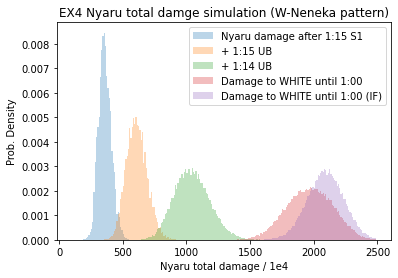

In [ ]:
# Time: 1:23
ex4start = lambda x : nyaruUB(NYARU['attack'] + 19756, NYARU['critical']+180,0.15,400, detail=x)
print(ex4start(True))
histUB = []
nyaruUB_ex4 = lambda x,y,z : nyaruUB(NYARU['attack'] + x, NYARU['critical']+y,z,400, detail=False)
nyaruUB_ex4WHITE = lambda x,y,z : nyaruUB(NYARU['attack'] + x, NYARU['critical']+y,z,400, detail=False, magic_defense=80)
DEBUG_FLAG = True
LUNA_EX4 = LUNA_3
for ev in range(0,100000):
  # UB time: 1:23, 1:21, 1:21, 1:15, 1:14, 1:11, 1:11/1:08
  # Nyaru Skill: S2, S1/x, A, S1, S2/x, A, S1, A, A, S1
  # Array: UB/1:23, UB/1:21, UB/1:21, attack, S1, UB/1:15, UB/1:14, UB/1:11, UB/1:11or1:08
  nyaruDamage = [0] * 11
  #1:25 before Nuneka
  otherBuff = (28+10.5) * (LV_MAX +1) 
  nunekaAttack = 7168 + 240 + 15 * LV_MAX # 5star, Rand12 with TP equiment ONLY
  nunekaBuff = 10.5 * (LV_MAX + 1) + (nunekaAttack + otherBuff) * 0.08
  nunekaCriticalBuff = 30 + 0.003 * (nunekaAttack + otherBuff)
  otherCriticalBuff = nunekaCriticalBuff
  otherCriticalDamageBuff = 0.1 # Nuneka UB
  #1:23 Nyaru 1st UB
  otherBuff +=  nunekaBuff + (18 + 6) * (LV_MAX +1) #Saren S1 (until 1:03) + Nyaru S2 (until 1:11)
  nyaruBuff = otherBuff + 20. * (LV_MAX +1) # Nuneka S1 (until 1:11)
  nyaruCriticalBuff = nunekaCriticalBuff + 100 # Nuneka S1 (until 1:11)
  nyaruCriticalDamageBuff = otherCriticalDamageBuff + 0.05 # Nuneka S1 (until 1:11)
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF # until 1:05
  nyaruDamage[0] = ubDamage
    #DEBUG
  if(DEBUG_FLAG):
    print('Nyaru start UB : ' + repr(nyaruUB(NYARU['attack'] + nyaruBuff, NYARU['critical']+180,0.15,400,detail=True)))
  # 1:22 - Nuneka 2nd UB
  nunekaBuff = 10.5 * (LV_MAX + 1) + (nunekaAttack + otherBuff) * 0.08
  nunekaCriticalBuff = 30 + 0.003 * (nunekaAttack + otherBuff)
  otherBuff += nunekaBuff
  otherCriticalBuff += nunekaCriticalBuff
  otherCriticalDamageBuff += 0.1
  #1:21 - Nyaru 2nd/3rd UB by Luna S1
  nyaruBuff += 7.5 * (LV_MAX +1)
  nyaruCriticalBuff += nunekaCriticalBuff + 100
  nyaruCriticalDamageBuff += 0.1
    #2nd UB
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF
  nyaruDamage[1] = ubDamage
    # 3rd UB
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF
  nyaruDamage[2] = ubDamage
    # Luna damage
  nyaruHurt = LunaS1(LUNA_EX4['attack'] + otherBuff, NYARU['defence_magic'], LUNA_EX4['critical']+otherCriticalBuff, otherCriticalDamageBuff)
  lunaCriticalRate = critical_rate(LUNA_EX4['critical'] + otherCriticalBuff, LV_MAX)
  if(DEBUG_FLAG):
    print('Luna critical rate at 1:21 : ' + repr(lunaCriticalRate))
    print('Luna hit Nyaru : ' + repr(nyaruHurt))
  # 1:18 Nyaru Attack
  nyaruDamage[3] = critical_damage(
      NYARU['attack'] + nyaruBuff,
      critical_rate(NYARU['critical'] + nyaruCriticalBuff, 400),
      nyaruCriticalDamageBuff )
  # Nyaru HP check
  nyaruHpAbsorbRate = 6. / (100 + 400 + 6)
  if sum(nyaruDamage[1:4]) * nyaruHpAbsorbRate < nyaruHurt:
    histUB.append(nyaruDamage)
    DEBUG_FLAG = False
    continue
  # 1:15 Nyaru S1
  nyaruDamage[4] =NyaruS1(NYARU['attack'] + nyaruBuff, 0, NYARU['critical'] + nyaruCriticalBuff, nyaruCriticalDamageBuff, 400)
  nyaruDamageWHITE = NyaruS1(NYARU['attack'] + nyaruBuff, 80, NYARU['critical'] + nyaruCriticalBuff, nyaruCriticalDamageBuff, 400)
  nyaruDamageWHITE += NyaruS1(NYARU['attack'] + nyaruBuff, 50, NYARU['critical'] + nyaruCriticalBuff, nyaruCriticalDamageBuff, 400)
  nyaruDamageWHITE += NyaruS1(NYARU['attack'] + nyaruBuff, 50, NYARU['critical'] + nyaruCriticalBuff, nyaruCriticalDamageBuff, 400)
  # 1:15 Saren S2
  otherBuff += 2.5 * (LV_MAX + 1)
  otherCriticalBuff += 20
  nyaruBuff += 2.5 * (LV_MAX + 1)
  nyaruCriticalBuff += 20
  # 1:14 Nyaru 4/5th UB by Luna S1
    # Luna S1
  nyaruHurt = LunaS1(LUNA_EX4['attack'] + otherBuff, NYARU['defence_magic'], LUNA_EX4['critical']+otherCriticalBuff, otherCriticalDamageBuff)
  if(DEBUG_FLAG):
    lunaCriticalRate = critical_rate(LUNA_EX4['critical'] + otherCriticalBuff, LV_MAX)
    print('Luna critical rate at 1:15 : ' + repr(lunaCriticalRate))
    print('Luna hit Nyaru : ' + repr(nyaruHurt))
  nyaruBuff += 7.5 * (LV_MAX +1)
  nyaruCriticalBuff += 100
    # Nyaru 4th UB
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF
  nyaruDamage[5] = ubDamage
    # Nyaru 5th UB (TP check)
  nyarutpBoost = 1 + NYARU['tp_boost'] / 100. + 0.15 + 0.05 # Nenek UB + Nuneka UB x2
  nyaruTP = round(90 * nyarutpBoost) * 2 + 170
  if(nyaruHurt < (1000 - nyaruTP) / 500. / nyarutpBoost * NYARU['hp']):
    histUB.append(nyaruDamage)
    DEBUG_FLAG = False
    continue
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF
  nyaruDamage[6] = ubDamage
  # Kill BLACK and MOVE to WHITE
  # 1:14 Saren UB
  otherBuff += 10.5 * (LV_MAX + 1)
  nyaruBuff += 10.5 * (LV_MAX + 1)
  # 1:14 Nuneka S1
  nyaruBuff += 20. * (LV_MAX +1)
  nyaruCriticalBuff += 100
  nyaruCriticalDamageBuff += 0.05
  # 1:13 Buff check - Saren UB at 1:25
  otherBuff -= 10.5 * (LV_MAX + 1)
  nyaruBuff -= 10.5 * (LV_MAX + 1)  
  # 1:12 Nyaru Attack to WHITE + 1:15 S1 AOE to 3 targets
  nyaruDamage[7] = nyaruDamageWHITE + critical_damage(NYARU['attack'] + nyaruBuff, critical_rate(NYARU['critical'] + nyaruCriticalBuff, 400), nyaruCriticalDamageBuff, 2.0, 80)
  # 1:11 Luna S1
  nyaruHurt = LunaS1(LUNA_EX4['attack'] + otherBuff, NYARU['defence_magic'], LUNA_EX4['critical']+otherCriticalBuff, otherCriticalDamageBuff)
  if(nyaruHurt > NYARU['hp'] or DEBUG_FLAG):
    print('> TL check - Nyaru killed by Luna at 1:11 (%d, %d)' % (nyaruHurt, NYARU['hp']))
  if(DEBUG_FLAG):
    lunaCriticalRate = critical_rate(LUNA_EX4['critical'] + otherCriticalBuff, LV_MAX)
    print('Luna critical rate at 1:11 : ' + repr(lunaCriticalRate))
    print('Luna hit Nyaru : ' + repr(nyaruHurt))
  nyaruBuff += 7.5 * (LV_MAX +1)
  nyaruCriticalBuff += 100
  # 1:11 Nyaru 6th UB
  ubDamage = nyaruUB_ex4WHITE(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF
  nyaruDamage[8] = ubDamage
  # 1:11 Neneka + Nuneka UB
  otherBuff += 28 * (LV_MAX + 1)
  nyaruBuff += 28 * (LV_MAX + 1)
  nunekaBuff = 10.5 * (LV_MAX +1) + (nunekaAttack +otherBuff) * 0.08
  nunekaCriticalBuff += 30 + (nunekaAttack +otherBuff) * 0.003
  otherBuff += nunekaBuff
  otherCriticalBuff += nunekaCriticalBuff
  otherCriticalDamageBuff += 0.1
  nyaruBuff += nunekaBuff
  nyaruCriticalBuff += nunekaCriticalBuff
  nyaruCriticalDamageBuff += 0.1
  # 1:11 Nyaru 7th UB
  ubDamage = nyaruUB_ex4WHITE(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruDamage[9] = ubDamage
  # 1:08 Nyaru 7th UB (IF)
    #Buff check (1:23 Nuneka, 1:21 Luna)
  nyaruBuff -= 20. * (LV_MAX +1)
  nyaruCriticalBuff -= 100
  nyaruCriticalDamageBuff -= 0.05
  nyaruBuff -= 7.5 * (LV_MAX +1)
  nyaruCriticalBuff -= 100
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruDamage[10] = ubDamage
  # END
  histUB.append(nyaruDamage)
  DEBUG_FLAG = False


hurtFlag = [int(bool(x[4])) for x in histUB]
counts, binedges = np.histogram(hurtFlag, bins=[-0.5,0.5,1.5])
print(' > TL check - Nyaru HP at 1:18 [FAIL, PASS] =[%d vs %d]' % (counts[0], counts[1]))

successFlag = [int(bool(x[6])) for x in histUB]
counts, binedges = np.histogram(successFlag, bins=[-0.5,0.5,1.5])
print(' > TL check - Nyaru TP at 1:14 [FAIL, PASS] =[%d vs %d]' % (counts[0], counts[1]))

fig, ax = plt.subplots()
damageSumBefore115 = [ sum(x[0:5])/10000. for x in histUB if x[4] > 0]
damageSum115 = [ sum(x[0:6])/10000. for x in histUB if x[5] > 0]
damageSum114 = [ sum(x[0:7])/10000. for x in histUB if x[6] > 0]
damageSumWHITE = [(x[7]+x[8]+x[9])/10000 + 500 for x in histUB if x[7] > 0]
damageSumWHITE_if = [(x[7]+x[8]+x[10])/10000 + 500 for x in histUB if x[7] > 0]
pltKwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=range(100,2500,10))
histBefore115 = plt.hist(damageSumBefore115, **pltKwargs, label='Nyaru damage after 1:15 S1')
hist115 = plt.hist(damageSum115, **pltKwargs, label='+ 1:15 UB')
hist114 = plt.hist(damageSum114, **pltKwargs, label='+ 1:14 UB')
histWHITE = plt.hist(damageSumWHITE, **pltKwargs, label='Damage to WHITE until 1:00')
histWHITE_if = plt.hist(damageSumWHITE_if, **pltKwargs, label='Damage to WHITE until 1:00 (IF)')
leg = ax.legend()
plt.title('EX4 Nyaru total damge simulation (W-Neneka pattern)')
plt.ylabel('Prob. Density')
plt.xlabel('Nyaru total damage / 1e4')

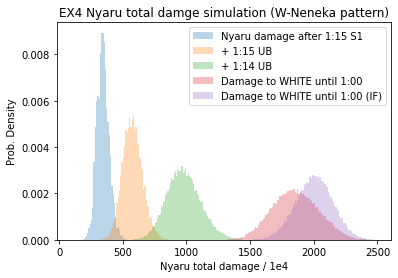

In [ ]:
# Optimize plots
fig, ax = plt.subplots()
pltKwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=range(100,2500,10))
histBefore115 = plt.hist(damageSumBefore115, **pltKwargs, label='Nyaru damage after 1:15 S1')
hist115 = plt.hist(damageSum115, **pltKwargs, label='+ 1:15 UB')
hist114 = plt.hist(damageSum114, **pltKwargs, label='+ 1:14 UB')
histWHITE = plt.hist(damageSumWHITE, **pltKwargs, label='Damage to WHITE until 1:00')
histWHITE_if = plt.hist(damageSumWHITE_if, **pltKwargs, label='Damage to WHITE until 1:00 (IF)')
leg = ax.legend()
plt.title('EX4 Nyaru total damge simulation (W-Neneka pattern)')
plt.ylabel('Prob. Density')
plt.xlabel('Nyaru total damage / 1e4')
plt.savefig('pcr_ex4.png')

In [ ]:
# Damage and buff check
print(LunaS1(LUNA_4['attack'] + 6 *(LV_MAX +1), NYARU['defence_magic'], LUNA_4['critical'] ))
print(nyaruUB(NYARU['attack'] + 19756, NYARU['critical']+180,0.15,enemyLv=400, lv=LV_MAX,detail=True, magic_defense=0))
print((nunekaAttack + (10.5 + 28 + 10.5 + 2.5) *(LV_MAX+1) +1300) * 0.003)
print(critical_rate(LUNA_4['critical'] + 30 + 70, LV_MAX))

9695
[15403, 61611, 240286]
65.979
0.7160000000000001


In [ ]:
# HP absord check
print(14808/nyaruHpAbsorbRate)
print(14808./1249290)
print(3367./294031)

1248808.0
0.011853132579305046
0.011451173515717731


In [ ]:
# Luna attack check (if crtical to kill Nyaru)
LunaAttack115 = round(23115 / 2.4 * 3.88)
overHP = (LunaAttack115 - (LUNA_4['attack'] - LUNA_3['attack']) + 6 * (LV_MAX +1))/ 3.88 * 2.4 - NYARU['hp']
print(overHP + NYARU['hp'])
LUNA_4['attack'] - LUNA_3['attack']
testOverHP = 23656 - NYARU['hp']
13873 - (testOverHP * 3.88 / 2.4) 

23502.061855670105


14194.716666666667

#### Nyaru TP check
* 1:15 Luna MUST hit **CRITICAL** at Nyaru
* 1:11 PASS with NO critical
* 1:00/0:58 WHITE perform All hit to Nyaru (if not, still OK at 0:57 with Luna S1)
* 0:44 Luna MUST hit **CRITICAL** + **1 hits** from WHITE boss

*ISSUE*: Nyaru hurt from WHITE at 0:44 is 1733/hit but not 1922 (calculated from data). IF SLv of Main 4 (WHITE) should be 250 not 500?

**SOLVED**: Buff clear at 1:00 was cancelled as well as the self buff.

In [ ]:
# Nyaru TP check
# 1:15
tpBoost = 15 + 5 *2 + NYARU['tp_boost']
hurtNyaru = hurt_for_UB(2, tpBoost, NYARU['tp_retain'], NYARU['hp'], NYARU['defence_magic'], 0)
print('Damage required at 1:15 - %d' % hurtNyaru)
# 1:11
tpBoost = 15 + 5*2 + NYARU['tp_boost']
hurtNyaru = hurt_for_UB(1, tpBoost, NYARU['tp_retain'], NYARU['hp'], NYARU['defence_magic'], 
                        kill_tp(tpBoost) + nuneka_tp(tpBoost))
print('Damage required at 1:11 - %d' % hurtNyaru)
# 1:00
tpBoost = 15 + 5 + NYARU['tp_boost']
tpBoost108 = 15 * 2 + 5*3 + NYARU['tp_boost']
tpBoost106 = 15 + 5*2 + NYARU['tp_boost']
hurtNyaru = hurt_for_UB(3, tpBoost, NYARU['tp_retain'], NYARU['hp'], NYARU['defence_magic'],
                        nuneka_tp(tpBoost108) +action_tp(tpBoost106) )
print('Damage required at 1:00 - %d' % hurtNyaru)
print('> Nuneka TP boost at 1:07 = %d'  % nuneka_tp(tpBoost108))
whiteS1 = 100 + 50 * 400 + (0.1 + 0.0005 * 400) * 5000
print('> Nyaru hurt per hit from WHITE S1 - %d' % (whiteS1/4/(1+NYARU['defence_magic']/100.)))
print('> WHITE damage at 1:00 - %d, %d, %d, %d' % (whiteS1/4, whiteS1/2, whiteS1*3/4, whiteS1))
# 0:44
tpBoost = 15 + 5 + NYARU['tp_boost']
hurtNyaru = hurt_for_UB(3, tpBoost, NYARU['tp_retain'], NYARU['hp'], NYARU['defence_magic'], 0)
print('Damage required at 0:44 - %d' % hurtNyaru)
whiteS1 = 100 + 50 * 400 + (0.1 + 0.0005 * 400) * (5000 +1 + 40 *500)
print('> Nyaru hurt per hit from WHITE S1 - %d' % (whiteS1/4/(1+NYARU['defence_magic']/100.)))
print('> WHITE damage at 0:44 - %d, %d, %d, %d' % (whiteS1/4, whiteS1/2, whiteS1*3/4, whiteS1))
nunekaAttack053 = NUNEKA_ATTACK + (28 * 2 + 10.5 + 10.5 + 2.5) * (LV_MAX +1)  # delta from 111
lunaAttack = LUNA_3['attack'] + (28 + 10.5 + 10.5 + 2.5) * (LV_MAX +1) + nunekaAttack053 * 0.08
print('> Luna damage at 0:44 - %d, %d/critical' % (lunaAttack, lunaAttack * 2 * 1.1))
hurtNyaru = hurt_for_UB(2, tpBoost, NYARU['tp_retain'], NYARU['hp'], NYARU['defence_magic'], 0)
print('> (IF) Damage required at 0:44 - %d' % hurtNyaru)
# 0:19
tpBoost = 15 +5 + NYARU['tp_boost']
hurtNyaru = hurt_for_UB(4, tpBoost, NYARU['tp_retain'], NYARU['hp'], NYARU['defence_magic'], nuneka_tp(tpBoost))
print('Damage required at 0:19 - %d' % hurtNyaru)
whiteS1 = 100 + 50 * 400 + (0.1 + 0.0005 * 400) * (5000 + 25 * 400 +1 + 40 *500)
print('> Nyaru hurt per hit from WHITE S1 - %d' % (whiteS1/4/(1+NYARU['defence_magic']/100.)))
print('> WHITE damage at 0:19 - %d, %d, %d, %d' % (whiteS1/4, whiteS1/2, whiteS1*3/4, whiteS1))
hurtNyaru = hurt_for_UB(3, tpBoost, NYARU['tp_retain'], NYARU['hp'], NYARU['defence_magic'], nuneka_tp(tpBoost))
print('> Damage required at 0:19 (Nyaru 3 actions ONLY) - %d' % hurtNyaru)

Damage required at 1:15 - 80082
Damage required at 1:11 - 33023
Damage required at 1:00 - 18417
> Nuneka TP boost at 1:07 = 217
> Nyaru hurt per hit from WHITE S1 - 1356
> WHITE damage at 1:00 - 5400, 10800, 16200, 21600
Damage required at 0:44 - 67102
> Nyaru hurt per hit from WHITE S1 - 1733
> WHITE damage at 0:44 - 6900, 13800, 20700, 27600
> Luna damage at 0:44 - 29926, 65838/critical
> (IF) Damage required at 0:44 - 84235
Damage required at 0:19 - 23842
> Nyaru hurt per hit from WHITE S1 - 1922
> WHITE damage at 0:19 - 7650, 15300, 22950, 30600
> Damage required at 0:19 (Nyaru 3 actions ONLY) - 40975
